In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
%cd /content/drive/MyDrive/ANPR

/content/drive/.shortcut-targets-by-id/1Dgr6QePEjMPt7M0PefZcsfFx_E-JhiK1/ANPR


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import urllib
import glob
%load_ext autoreload
%autoreload 2

In [ ]:
!nvidia-smi

Thu May  6 10:55:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
!ls -l /usr/local | grep cuda

lrwxrwxrwx  1 root root    9 Apr 21 13:32 cuda -> cuda-11.0
drwxr-xr-x 16 root root 4096 Apr 21 13:26 cuda-10.0
drwxr-xr-x 15 root root 4096 Apr 21 13:28 cuda-10.1
drwxr-xr-x  1 root root 4096 Apr 21 13:30 cuda-11.0


In [ ]:
!ls 

ANPR.ipynb	   data.zip		Indian_eu_br_us_plates_compressed
darknet		   images		train.txt
darknet53.conv.74  indian_eu_br_us.csv	val.txt


In [ ]:
# !nvcc --help

In [24]:
df = pd.read_csv("/content/drive/MyDrive/ANPR/indian_eu_br_us.csv")
df.head()

image_name  image_width  image_height  ...  bottom_x  bottom_y      number
0  licensed_car0          806           466  ...  0.868486  0.688841   MH15TC554
1  licensed_car1          494           449  ...  0.582996  1.000000  MH02CB4545
2  licensed_car2          500           314  ...  0.230000  0.828025  MH20TC830C
3  licensed_car3          500           469  ...  0.718000  0.765458    KA031351
4  licensed_car4         1001           563  ...  0.865135  0.984014   TN0600000

[5 rows x 8 columns]

In [25]:
#x:center_x, y:center_y, w:image_width, h:image_height
data_dict = {}
data_dict['x'] = (df['top_x']+df['bottom_x'])/2
data_dict['y'] = (df['top_y']+df['bottom_y'])/2
data_dict['w'] = df['bottom_x'] - df['top_x']
data_dict['h'] = df['bottom_y']- df['top_y']

df_new = pd.DataFrame(data_dict)
df_new.head()

x         y         w         h
0  0.795285  0.638412  0.146402  0.100858
1  0.372470  0.925390  0.421053  0.149220
2  0.156000  0.762739  0.148000  0.130573
3  0.576000  0.716418  0.284000  0.098081
4  0.536963  0.687389  0.656344  0.593250

In [26]:
df_new.shape

(671, 4)

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-05-06 08:59:53--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  22.6MB/s    in 7.6s    

2021-05-06 09:00:02 (20.4 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:

!git clone https://github.com/kriyeng/darknet/
%cd darknet

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 10.13 MiB | 4.65 MiB/s, done.
Resolving deltas: 100% (6742/6742), done.
Checking out files: 100% (1956/1956), done.
/content/drive/.shortcut-targets-by-id/1Dgr6QePEjMPt7M0PefZcsfFx_E-JhiK1/ANPR/darknet


In [ ]:
%cd /content/drive/MyDrive/ANPR/darknet
!make

/content/drive/.shortcut-targets-by-id/1Dgr6QePEjMPt7M0PefZcsfFx_E-JhiK1/ANPR/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sender::write(const char*)’:
./src/http_stream.cpp:228:21: warning: unused variable ‘n’ [-Wunused-variable]
                 int n = _write(client, outputbuf, outlen);
                     ^
gcc -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-u

In [9]:
# dirs = df['image_name'].values
# dirs

In [ ]:
#writing files to the darknet data repository
data = {}
ppath = "/content/drive/MyDrive/ANPR/Indian_eu_br_us_plates_compressed"
dpath = "/content/drive/MyDrive/ANPR/darknet/data/obj"
dirs = df['image_name'].values
for i, ls in enumerate(dirs):
    path = os.path.join(ppath,ls)
    path = path+".jpeg"
    img = cv2.imread(path)
    # print(path)
    name = "car_"+str(i)+".jpeg"
    dest = os.path.join(dpath, name)
    cv2.imwrite(dest, img)
    data[name] = img


In [ ]:
dirs = df['image_name'].values
for i, ls in enumerate(dirs):
    name = "car_"+str(i)+".jpeg"
    df['image_name'][i] = name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df.head()

image_name  image_width  image_height  ...  bottom_x  bottom_y      number
0  car_0.jpeg          806           466  ...  0.868486  0.688841   MH15TC554
1  car_1.jpeg          494           449  ...  0.582996  1.000000  MH02CB4545
2  car_2.jpeg          500           314  ...  0.230000  0.828025  MH20TC830C
3  car_3.jpeg          500           469  ...  0.718000  0.765458    KA031351
4  car_4.jpeg         1001           563  ...  0.865135  0.984014   TN0600000

[5 rows x 8 columns]

In [ ]:
#write the annotated files to the 'label' folder
for i in range(len(df_new)):
    f = open('/content/drive/MyDrive/ANPR/darknet/data/obj/car_{}.txt'.format(i),'w+')
    f.write('{} {} {} {} {}'.format(0,df_new['x'][i], df_new['y'][i], df_new['w'][i], df_new['h'][i]))
    f.close()

In [ ]:
def split_data():
  """
  split the dataset into train and val dataset with 9:1 ratio
  """
  current_dir = "/content/drive/MyDrive/ANPR/darknet/data/obj"
  # Percentage of images to be used for the valid set
  percentage_test = 10;
  # Create train.txt and valid.txt
  file_train = open('/content/drive/MyDrive/ANPR/darknet/data/train.txt', 'w')  
  file_test = open('/content/drive/MyDrive/ANPR/darknet/data/val.txt', 'w')
  # Populate train.txt and valid.txt
  counter = 1  
  index_test = round(100 / percentage_test)  
  for file in glob.iglob(os.path.join(current_dir, '*.jpeg')):  
      title, ext = os.path.splitext(os.path.basename(file))
      # print(title)
      if counter == index_test:
          counter = 1
          file_test.write(current_dir + "/" + title + '.jpeg' + "\n")
      else:
          file_train.write(current_dir + "/" + title + '.jpeg' + "\n")
          counter = counter + 1

In [ ]:
split_data()

#### create configuration files to train darknet on custom dataset for number plate detection

In [ ]:
%cd /content/drive/MyDrive/ANPR/darknet/data

/content/drive/.shortcut-targets-by-id/1Dgr6QePEjMPt7M0PefZcsfFx_E-JhiK1/ANPR/darknet/data


In [ ]:
%%writefile obj.names
number_plate

Overwriting obj.names


In [ ]:
%%writefile obj.data
classes = 1 
train  = /content/drive/MyDrive/ANPR/darknet/data/train.txt
valid  = /content/drive/MyDrive/ANPR/darknet/data/val.txt
names = /content/drive/MyDrive/ANPR/darknet/data/obj.names
backup = /content/drive/MyDrive/ANPR/darknet/backup

Overwriting obj.data


In [ ]:
#create mymodel.cfg configuration file for our custom dataset
!cat /content/drive/MyDrive/ANPR/darknet/cfg/yolov3.cfg >> /content/drive/MyDrive/ANPR/darknet/cfg/custom_yolov3.cfg

In [7]:
 from google.colab.patches import cv2_imshow

In [34]:
#preparing training data for OCR
ppath = "/content/drive/MyDrive/ANPR/Indian_eu_br_us_plates_compressed"
dpath = "/content/drive/MyDrive/ANPR/darknet/data/obj"
ocr_dest = "/content/drive/MyDrive/ANPR/data_ocr/train"
dirs = df['image_name'].values
for i, ls in enumerate(dirs):
    path = os.path.join(ppath,ls)
    path = path+".jpeg"
    # print(path)
    img = cv2.imread(path)
    name_txt = "/car_"+str(i)+".txt"
    txt_path = dpath + name_txt
    with open(txt_path, 'r') as f:
      str_op = f.read()  
    _, x, y, w, h = str_op.split(" ")
    x,y,w,h = float(x), float(y), float(w), float(h)
    height, width, _ = img.shape
    top_x, top_y =max(0, int((x-w/2)*width)), int((y-h/2)*height)
    xplusw = top_x+int(w*width)
    yplush = top_y+int(h*height)
    cropped_img = img[top_y:yplush, top_x:xplusw]
    # print(img.shape)
    # print(top_x, top_y, xplusw, yplush)
    # cv2_imshow(cropped_img)
    d_name = df["number"][i]+".jpeg"
    # print(i)
    dest = os.path.join(ocr_dest, d_name)
    cv2.imwrite(dest, cropped_img)

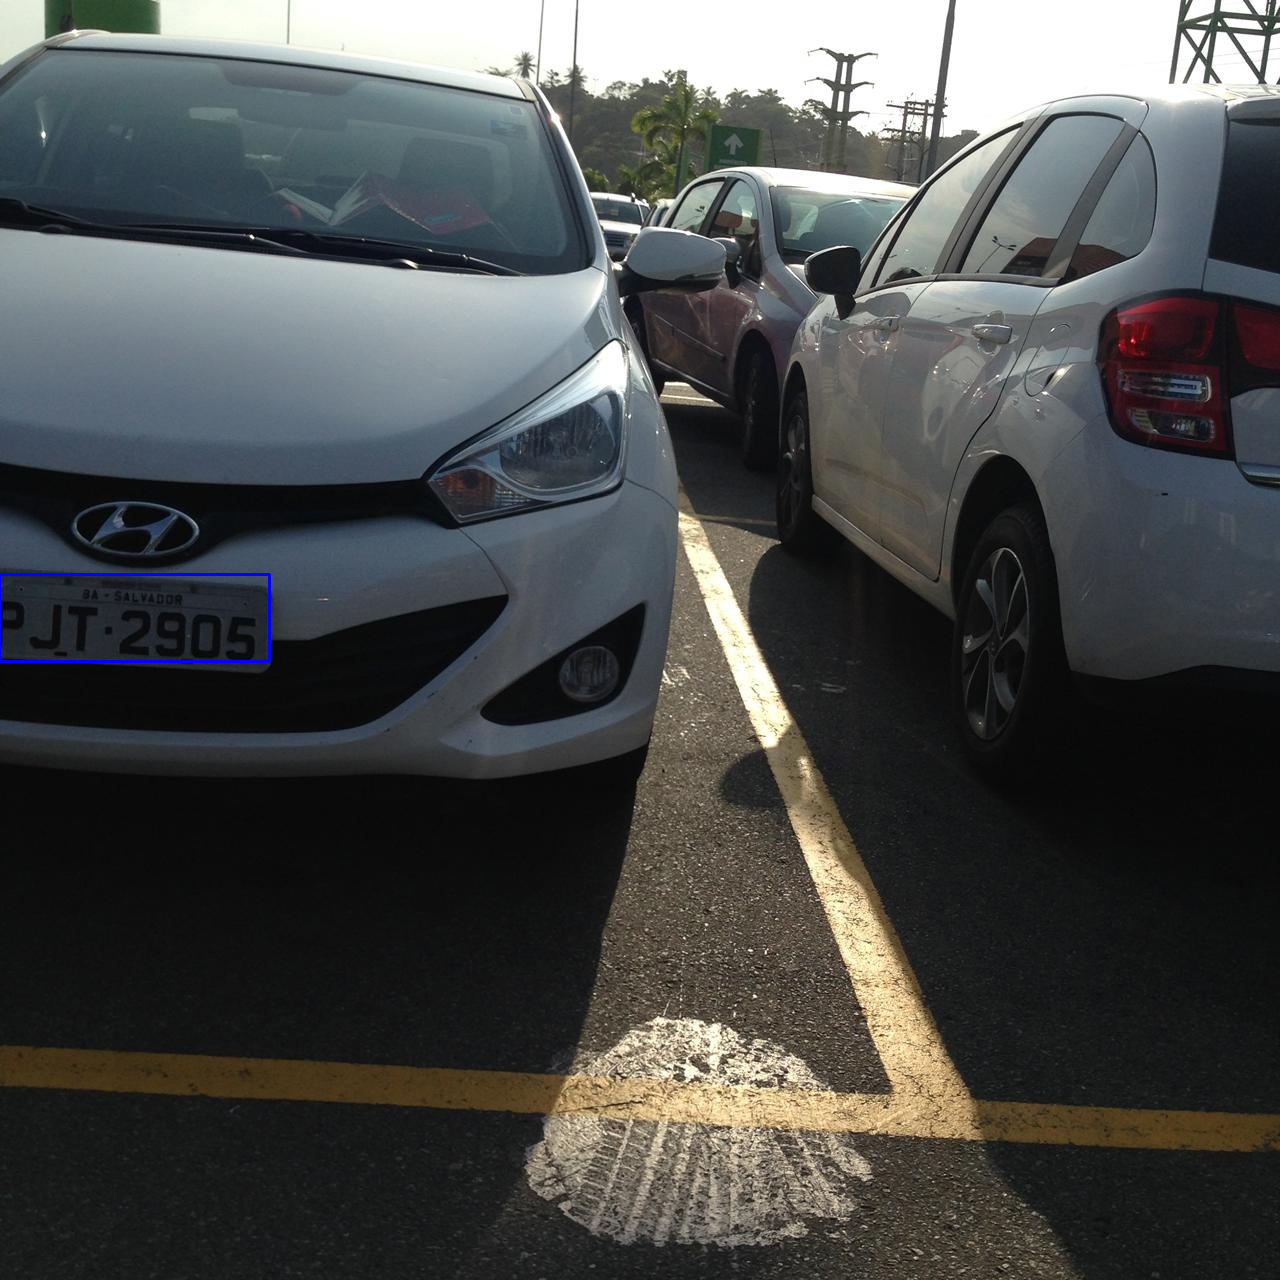

In [32]:
#plot bounding box
file_path = '/content/drive/MyDrive/ANPR/darknet/data/obj'
img =cv2.imread( "/content/drive/MyDrive/ANPR/darknet/data/obj/car_437.jpeg").copy()
txt_path = "/content/drive/MyDrive/ANPR/darknet/data/obj/car_437.txt"
ocr_dest = "/content/drive/MyDrive/ANPR/data_ocr/train"
with open(txt_path, 'r') as f:
  str_op = f.read()
_, x, y, w, h = str_op.split(" ")
x,y,w,h = float(x), float(y), float(w), float(h)
height, width, _ = img.shape
top_x, top_y = int((x-w/2)*width), int((y-h/2)*height)
bottom_x, bottom_y =  int((x+w/2)*width), int((y+h/2)*height)
color = (255, 0, 0)
image = cv2.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), color,  2)
cv2_imshow( image)

In [ ]:
img.shape

(217, 350, 3)

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1Dgr6QePEjMPt7M0PefZcsfFx_E-JhiK1/ANPR/darknet/data


In [51]:
#let's train the darknet on our custom dataset
%cd /content/drive/MyDrive/ANPR/darknet
!chmod +x darknet
! ./darknet detector train /content/drive/MyDrive/ANPR/darknet/data/obj.data /content/drive/MyDrive/ANPR/darknet/cfg/custom_yolov3.cfg /content/drive/MyDrive/ANPR/darknet/backup/custom_yolov3_last.weights -dont_show

Streaming output truncated to the last 5000 lines.
Region 82 Avg IOU: 0.813744, Class: 0.999882, Obj: 0.976580, No Obj: 0.003496, .5R: 1.000000, .75R: 1.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.800596, Class: 0.998981, Obj: 0.898840, No Obj: 0.000090, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.865018, Class: 0.999880, Obj: 0.946106, No Obj: 0.001456, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 94 Avg IOU: 0.904238, Class: 0.999943, Obj: 0.883316, No Obj: 0.000646, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000080, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.946442, Class: 0.999760, Obj: 0.431219, No Obj: 0.001784, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: 0.850655, Class: 0.998405, Obj: 0.681253, No Obj: 0.000511, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.88623

## Output

/content/drive/MyDrive/ANPR/darknet/data/obj/car_5.jpeg
[[112.5, 270.5, 159, 53]]


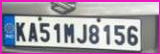

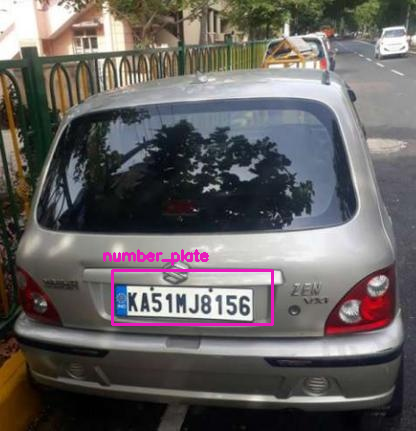

/content/drive/MyDrive/ANPR/darknet/data/obj/car_7.jpeg
[[249.5, 252.5, 147, 77]]


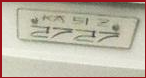

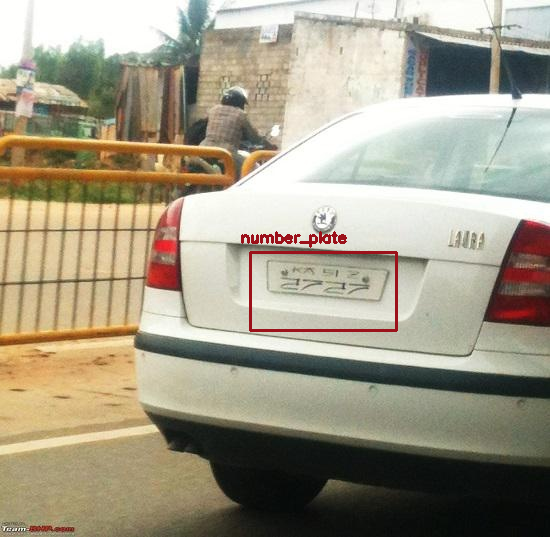

/content/drive/MyDrive/ANPR/darknet/data/obj/car_39.jpeg
[[135.5, 245.0, 161, 104]]


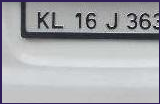

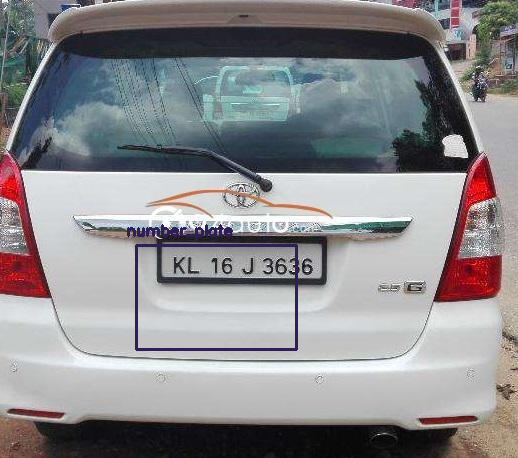

/content/drive/MyDrive/ANPR/darknet/data/obj/car_46.jpeg
[[125.0, 183.0, 92, 40], [121.0, 182.5, 104, 41]]


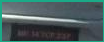

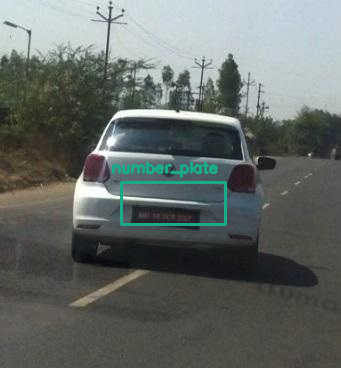

/content/drive/MyDrive/ANPR/darknet/data/obj/car_49.jpeg
[[44.0, 311.0, 134, 58], [32.5, 317.0, 155, 46]]


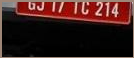

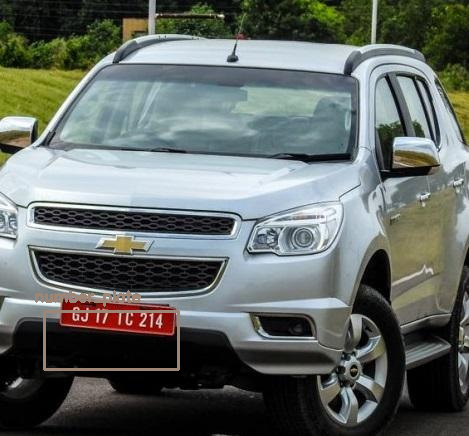

/content/drive/MyDrive/ANPR/darknet/data/obj/car_51.jpeg
[[90.5, 247.0, 169, 56]]


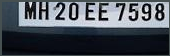

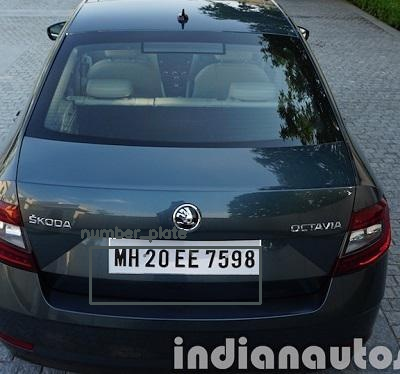

/content/drive/MyDrive/ANPR/darknet/data/obj/car_55.jpeg
[[92.5, 258.5, 207, 105]]


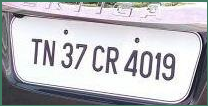

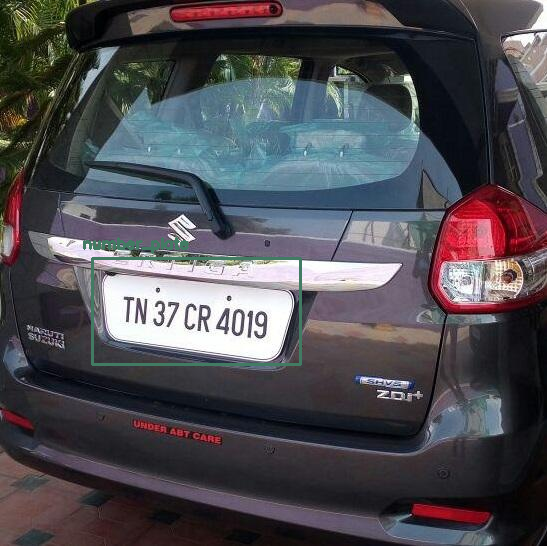

/content/drive/MyDrive/ANPR/darknet/data/obj/car_58.jpeg
[[136.5, 201.5, 161, 47]]


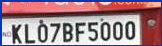

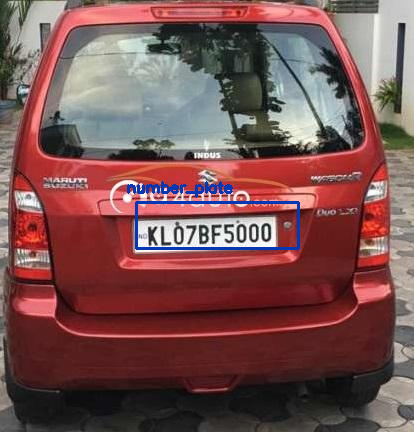

/content/drive/MyDrive/ANPR/darknet/data/obj/car_61.jpeg
[[54.5, 149.5, 103, 57]]


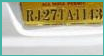

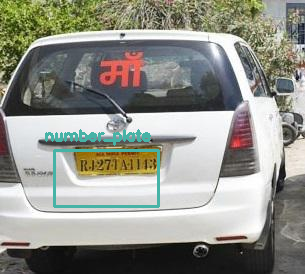

In [98]:

def get_output(model):
    layer_names = model.getLayerNames()
    output_layers = [layer_names[i[0]-1]for i in model.getUnconnectedOutLayers()]
    return output_layers

def draw_preds(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # print(img)
    image=img[int(y):int(y_plus_h),int(x):int(x_plus_w)]
    cv2_imshow(image)
    cv2.imwrite("/content/drive/MyDrive/ANPR/test_op/cropped.jpg",image)
arr = [5,7,39, 46, 49, 51, 55, 58, 61]
for el in arr:
  path =  "/content/drive/MyDrive/ANPR/darknet/data/obj/car_"+str(el)+".jpeg"
  print(path)
  image = cv2.imread(path)
  Width = image.shape[0]
  Height = image.shape[1]
  scale_factor = 0.00392
  classes = None
  weight = "/content/drive/MyDrive/ANPR/darknet/backup/custom_yolov3_last.weights"
  config = "/content/drive/MyDrive/ANPR/darknet/cfg/custom_yolov3.cfg"
  with open("/content/drive/MyDrive/ANPR/darknet/data/obj.names", 'r') as f:
      classes = [line.strip() for line in f.readlines()]


  COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

  model = cv2.dnn.readNet(weight, config)

  blob = cv2.dnn.blobFromImage(image, scale_factor, (416,416), (0,0,0), True, crop=False)

  model.setInput(blob)

  outputs = model.forward(get_output(model))

  class_ids = []
  confidences = []
  bounding_boxes = []
  conf_threshold = 0.5
  nms_threshold = 0.5

  for output in outputs:
      for detection in output:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.5:
              center_x = int(detection[0]*Width)
              center_y = int(detection[1]*Height)
              w = int(detection[2] * Width)
              h = int(detection[3] * Height)
              x = center_x - w / 2
              y = center_y - h / 2
              class_ids.append(class_id)
              confidences.append(float(confidence))
              bounding_boxes.append([x,y,w,h])
  print(bounding_boxes)        
  indices = cv2.dnn.NMSBoxes(bounding_boxes,confidences,conf_threshold,nms_threshold)

  for i in indices:
      i = i[0]
      box = bounding_boxes[i]
      x,y,w,h = box[0],box[1],box[2],box[3]
      draw_preds(image,class_ids[i],confidences[i],round(x),round(y),round(x+w),round(y+h))

  cv2_imshow(image)
  cv2.waitKey()

  cv2.imwrite("plate-detection.jpg",image)
  cv2.destroyAllWindows()     